O PySentimiento é uma das bibliotecas mais interessantes atualmente para análise de sentimentos e emoções com suporte a vários idiomas, incluindo português.

Ele foi criado sobre modelos BERT e RoBERTa já pré-treinados e afinados (fine-tuned) para tarefas de NLP social, como:
✅ Análise de sentimentos
✅ Análise de emoções
✅ Detecção de ódio
✅ Detecção de ironia

| Recurso                | Descrição                              |
| ---------------------- | -------------------------------------- |
| **Idiomas suportados** | en, es, it, pt, fr, ca, eu, gl         |
| **Tarefas**            | Sentiment, Emotion, Hate Speech, Irony |
| **Base**               | Modelos BERT/RoBERTa fine-tuned        |
| **Instalação**         | `pip install pysentimiento`            |


In [96]:
import pandas as pd

import emoji
from pysentimiento import create_analyzer


import spacy

import vader
import textblob

import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import plotly.graph_objects as go

In [68]:
comentarios = pd.read_csv("comentarios.csv")
comentarios = comentarios[["date", "app_version", "score", "system", "app", "content"]]
comentarios.head()

,date,app_version,score,system,app,content
0,2025-05-27 18:54:37,18.7.0,5,Android,Claro,legal 😎
1,2025-05-27 18:10:04,18.6.0,5,Android,Claro,Encontro facilidade por aqui 👏
2,2025-05-27 17:49:18,18.7.0,5,Android,Claro,muito bom
3,2025-05-27 17:46:20,NaN,1,Android,Claro,ruim que vc deseja não tem informações
4,2025-05-27 17:20:22,18.7.0,5,Android,Claro,melhor do mundo


In [69]:
comentarios = comentarios[:100]

**Processamento dos Emojis**

In [70]:
def remover_emojis(texto):
    return emoji.demojize(texto, language='pt')

comentarios["comentario_sem_emoji"] = comentarios["content"].apply(remover_emojis)
comentarios.head()


,date,app_version,score,system,app,content,comentario_sem_emoji
0,2025-05-27 18:54:37,18.7.0,5,Android,Claro,legal 😎,legal :rosto_sorridente_com_óculos_escuros:
1,2025-05-27 18:10:04,18.6.0,5,Android,Claro,Encontro facilidade por aqui 👏,Encontro facilidade por aqui :mãos_aplaudindo:
2,2025-05-27 17:49:18,18.7.0,5,Android,Claro,muito bom,muito bom
3,2025-05-27 17:46:20,NaN,1,Android,Claro,ruim que vc deseja não tem informações,ruim que vc deseja não tem informações
4,2025-05-27 17:20:22,18.7.0,5,Android,Claro,melhor do mundo,melhor do mundo


|Tipo de Análise | Informativo |
|----------------|-------------|
| emotion        | aaaa        |
| irony          | aaaa        |
| hate_speech    | aaaa        |
| sentiment      | aaaa        |

# Análise de Sentimento

**pysentimiento**
- Biblioteca que oferece modelos baseados em BERT, fine-tunados para emoções e sentimento em português.
- Usa modelos robustos, prontos para uso.

✅ Pontos positivos:
Muito mais preciso.

Entende contexto, ironia, gírias e até alguns emojis.

Modelos modernos.

❌ Pontos negativos:
Mais pesado.

Pode exigir mais tempo de execução.

Não personalizável facilmente.

## Funções

In [71]:
#Função para realizar todas as análises
analyzers = {
    "irony": create_analyzer(task="irony", lang="pt"),
    "hate_speech": create_analyzer(task="hate_speech", lang="pt"),
    "sentiment": create_analyzer(task="sentiment", lang="pt"),
    "emotion": create_analyzer(task="emotion", lang="pt")
}

def analisar_sentimento_todos(texto, analyzers=analyzers):

    if not isinstance(texto, str) or not texto.strip():
        return pd.Series()

    dados = {}

    for tipo, analyzer in analyzers.items():
        resultado = analyzer.predict(texto)

        saida = resultado.output[0] if resultado.output else None
        dados[f"{tipo}_output"] = saida

        for k, v in resultado.probas.items():
            dados[f"{tipo}_{k}"] = v

    return pd.Series(dados)


In [97]:
resultados = comentarios["comentario_sem_emoji"].apply(analisar_sentimento_todos)

df_resultado = pd.concat([comentarios, resultados], axis=1)

df_resultado.head()

,date,app_version,score,system,app,content,comentario_sem_emoji,irony_output,irony_not ironic,irony_ironic,...,emotion_love,emotion_nervousness,emotion_optimism,emotion_pride,emotion_realization,emotion_relief,emotion_remorse,emotion_sadness,emotion_surprise,emotion_neutral
0,2025-05-27 18:54:37,18.7.0,5,Android,Claro,legal 😎,legal :rosto_sorridente_com_óculos_escuros:,i,0.000037,0.999963,...,0.003169,0.000142,0.001385,0.005727,0.002231,0.003187,0.000266,0.001186,0.000667,0.015898
1,2025-05-27 18:10:04,18.6.0,5,Android,Claro,Encontro facilidade por aqui 👏,Encontro facilidade por aqui :mãos_aplaudindo:,i,0.000038,0.999962,...,0.000182,0.000161,0.004324,0.001628,0.008519,0.003262,0.000151,0.000789,0.000126,0.913299
2,2025-05-27 17:49:18,18.7.0,5,Android,Claro,muito bom,muito bom,i,0.000039,0.999961,...,0.001996,0.000083,0.002181,0.001921,0.001108,0.000428,0.000251,0.000656,0.000932,0.006966
3,2025-05-27 17:46:20,NaN,1,Android,Claro,ruim que vc deseja não tem informações,ruim que vc deseja não tem informações,i,0.000037,0.999963,...,0.000237,0.001636,0.003698,0.000424,0.004252,0.001461,0.000453,0.043749,0.000267,0.294686
4,2025-05-27 17:20:22,18.7.0,5,Android,Claro,melhor do mundo,melhor do mundo,i,0.000038,0.999962,...,0.001119,0.000077,0.004919,0.003593,0.001038,0.000635,0.000231,0.000503,0.000280,0.013483


In [73]:
#Função para realizar apenas uma análise
def analisar_sentimento(texto):
    resultado = analyzer.predict(texto)

    if resultado.output:
        saida = resultado.output[0]
    else:
        saida = None

    dados = {'output':  saida}

    for emocao, prob in resultado.probas.items():
        dados[emocao] = prob

    return pd.Series(dados)

In [82]:
analyzer = create_analyzer(task="sentiment", lang="pt")

resultados = comentarios["comentario_sem_emoji"].apply(analisar_sentimento)

df_resultado = pd.concat([comentarios, resultados], axis=1)

df_resultado.head()

,date,app_version,score,system,app,content,comentario_sem_emoji,output,NEG,NEU,POS
0,2025-05-27 18:54:37,18.7.0,5,Android,Claro,legal 😎,legal :rosto_sorridente_com_óculos_escuros:,P,0.003867,0.035022,0.961111
1,2025-05-27 18:10:04,18.6.0,5,Android,Claro,Encontro facilidade por aqui 👏,Encontro facilidade por aqui :mãos_aplaudindo:,P,0.003249,0.035621,0.961130
2,2025-05-27 17:49:18,18.7.0,5,Android,Claro,muito bom,muito bom,P,0.001626,0.005355,0.993020
3,2025-05-27 17:46:20,NaN,1,Android,Claro,ruim que vc deseja não tem informações,ruim que vc deseja não tem informações,N,0.165725,0.818145,0.016130
4,2025-05-27 17:20:22,18.7.0,5,Android,Claro,melhor do mundo,melhor do mundo,P,0.002164,0.010966,0.986870


## Análises

In [98]:
df_resultado.head()

,date,app_version,score,system,app,content,comentario_sem_emoji,irony_output,irony_not ironic,irony_ironic,...,emotion_love,emotion_nervousness,emotion_optimism,emotion_pride,emotion_realization,emotion_relief,emotion_remorse,emotion_sadness,emotion_surprise,emotion_neutral
0,2025-05-27 18:54:37,18.7.0,5,Android,Claro,legal 😎,legal :rosto_sorridente_com_óculos_escuros:,i,0.000037,0.999963,...,0.003169,0.000142,0.001385,0.005727,0.002231,0.003187,0.000266,0.001186,0.000667,0.015898
1,2025-05-27 18:10:04,18.6.0,5,Android,Claro,Encontro facilidade por aqui 👏,Encontro facilidade por aqui :mãos_aplaudindo:,i,0.000038,0.999962,...,0.000182,0.000161,0.004324,0.001628,0.008519,0.003262,0.000151,0.000789,0.000126,0.913299
2,2025-05-27 17:49:18,18.7.0,5,Android,Claro,muito bom,muito bom,i,0.000039,0.999961,...,0.001996,0.000083,0.002181,0.001921,0.001108,0.000428,0.000251,0.000656,0.000932,0.006966
3,2025-05-27 17:46:20,NaN,1,Android,Claro,ruim que vc deseja não tem informações,ruim que vc deseja não tem informações,i,0.000037,0.999963,...,0.000237,0.001636,0.003698,0.000424,0.004252,0.001461,0.000453,0.043749,0.000267,0.294686
4,2025-05-27 17:20:22,18.7.0,5,Android,Claro,melhor do mundo,melhor do mundo,i,0.000038,0.999962,...,0.001119,0.000077,0.004919,0.003593,0.001038,0.000635,0.000231,0.000503,0.000280,0.013483


In [100]:
df_resultado.columns

Index(['date', 'app_version', 'score', 'system', 'app', 'content',
       'comentario_sem_emoji', 'irony_output', 'irony_not ironic',
       'irony_ironic', 'hate_speech_output', 'hate_speech_Sexism',
       'hate_speech_Body', 'hate_speech_Racism', 'hate_speech_Ideology',
       'hate_speech_Homophobia', 'sentiment_output', 'sentiment_NEG',
       'sentiment_NEU', 'sentiment_POS', 'emotion_output',
       'emotion_admiration', 'emotion_amusement', 'emotion_anger',
       'emotion_annoyance', 'emotion_approval', 'emotion_caring',
       'emotion_confusion', 'emotion_curiosity', 'emotion_desire',
       'emotion_disappointment', 'emotion_disapproval', 'emotion_disgust',
       'emotion_embarrassment', 'emotion_excitement', 'emotion_fear',
       'emotion_gratitude', 'emotion_grief', 'emotion_joy', 'emotion_love',
       'emotion_nervousness', 'emotion_optimism', 'emotion_pride',
       'emotion_realization', 'emotion_relief', 'emotion_remorse',
       'emotion_sadness', 'emotion_surpris

In [115]:
df_resultado['emotion_output'].unique(), df_resultado['sentiment_output'].unique()

(array(['admiration', 'neutral', None, 'disapproval', 'gratitude',
        'disappointment', 'caring', 'annoyance', 'approval', 'remorse',
        'love', 'desire', 'joy', 'optimism', 'anger'], dtype=object),
 array(['P', 'N'], dtype=object))

In [111]:
df_resultado.groupby(['sentiment_output','emotion_output']).agg({'emotion_output':'count'})

emotion_output
sentiment_output emotion_output                
N                admiration                  11
                 anger                        1
                 annoyance                    1
                 approval                     2
                 caring                       1
                 desire                       2
                 disappointment               4
                 disapproval                  5
                 gratitude                    1
                 neutral                     11
                 remorse                      1
P                admiration                  45
                 approval                     2
                 gratitude                    1
                 joy                          1
                 love                         1
                 neutral                      5
                 optimism                     1

In [ ]:
# Labels: nós do Sankey
labels = ['Admiration', 'Anger', 'Annoyance', 'Approval', 'Caring'
          'Desire', 'Disappointment', 'Disapproval', 'Gratitude', 'Neutro',
          'Remorse', 'Joy', 'Love', 'Optimism',
          'Pastel', 'Positive']

# Fonte (emoções) - índices
source = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, # Destino para Neutro
          0, 3, 8, 11, 12, 9, 13]  # Destino para Posito

# Destino (sentimentos) - índices
target = [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, # Destino para Neutro
          15, 15, 15, 15, 15, 15, 15]  # Destino para Posito

# Valores dos fluxos
value = [11, 1, 1, 2, 1, 2, 4, 5, 1, 11, 1, # Destino para Neutro
         45, 2, 1, 1, 1, 5, 1] # Destino para Posito

GRÁFICO HORRÍVELMENTE CHATO DE FAZER

In [127]:
import plotly.graph_objects as go

# Labels: nós do Sankey
labels = ['Admiration', 'Anger', 'Annoyance', 'Approval', 'Caring'
          'Desire', 'Disappointment', 'Disapproval', 'Gratitude', 'Neutro',
          'Remorse', 'Joy', 'Love', 'Optimism',
          'Neutro', 'Positive']

# Fonte (emoções) - índices
source = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, # Destino para Neutro
          0, 3, 8, 10, 11, 9, 12]  # Destino para Positivo

# Destino (sentimentos) - índices
target = [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, # Destino para Neutro
          14, 14, 14, 14, 14, 14, 14]  # Destino para Positivo

# Valores dos fluxos
value = [11, 1, 1, 2, 1, 2, 4, 5, 1, 11, 1, # Destino para Neutro
         45, 2, 1, 1, 1, 5, 1] # Destino para Positivo

# Criar Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels
    ),
    link=dict(
      source=source,
      target=target,
      value=value
  ))])

fig.update_layout(title_text="Sankey: Emoções para Sentimentos Diversos", font_size=10)
fig.show()

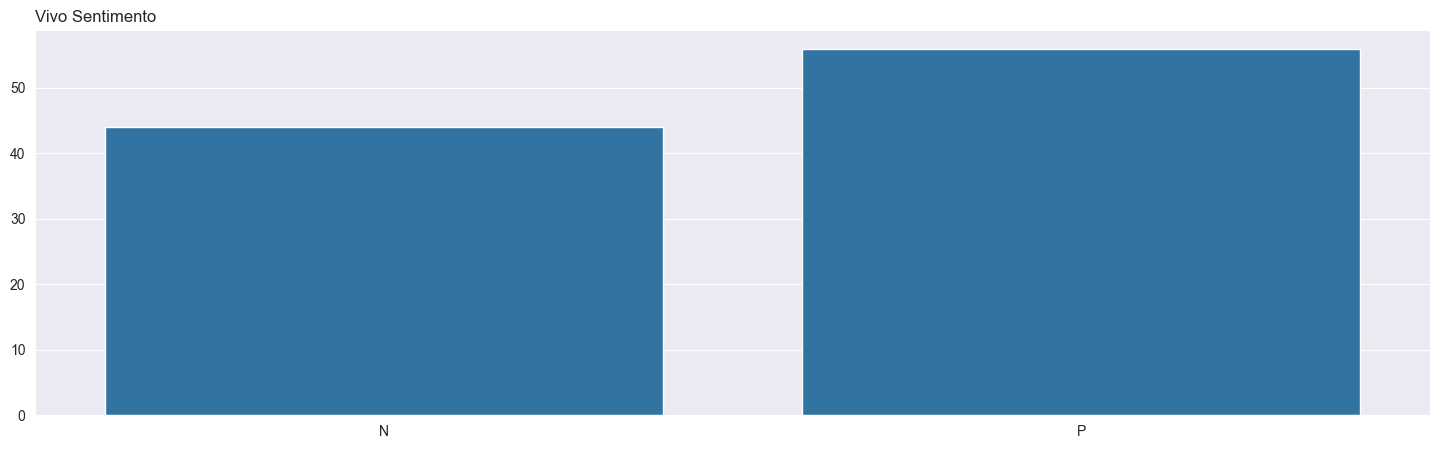

In [94]:
grafico = df_resultado[df_resultado["app"] == "Claro"]
grafico = grafico["output"].value_counts().sort_index()

sns.set_style("darkgrid")
fig, axes = plt.subplots(figsize=(18, 5))

_ = sns.barplot(grafico)
_ = plt.title("Vivo Sentimento", loc="left")
_ = plt.xlabel("")
_ = plt.ylabel("")

# Classificação de Temas